## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

TODO: redo this with grouped vars, so something that's an eqtl for multiple e genes doesn't count mutliple times

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress


from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

# load data

In [174]:
# load in the data from all tissues
vep_df = load_across_tissues(config, load_vep)
vep_df['variant_id'] = vep_df['ID']

In [175]:
# test out removing 1 var credible sets??
vep_df['num_vars'] = vep_df['variant_list'].apply(ast.literal_eval).apply(len)
print(len(vep_df))
#vep_df = vep_df[vep_df['num_vars']>1]
print(len(vep_df))


41146
41146


In [176]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

In [177]:
# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
qtls_grouped = vep_df.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_full_id':list, 
                                                                                'INFO':'first', 
                                                                                'orig_cs_dataset':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'lead_variant_pos':'first', 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
qtls_grouped['num_e_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_e_')/2
qtls_grouped['num_pc_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


In [178]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes = qtls_grouped[qtls_grouped['exclusive_label']=='shared'].explode(['orig_cs_dataset', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'orig_cs_dataset']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'orig_cs_dataset']).agg({'num_vars':min})
cs_sizes_pivot = cs_sizes.pivot_table(index='lead_variant_id', 
                           columns='orig_cs_dataset', 
                           values='num_vars', 
                           fill_value=0).reset_index()

<AxesSubplot: xlabel='pc_order', ylabel='Percent'>

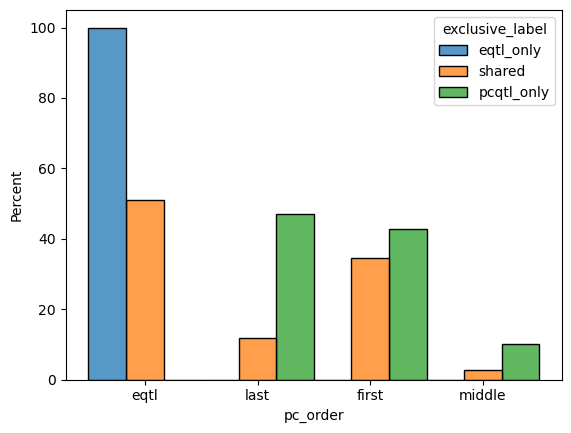

In [117]:
sns.histplot(qtls_grouped.explode('pc_order'), hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

In [118]:
vep_df = qtls_grouped

## VEP
vep annotates with variant categories

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [119]:
# as an example
vep_df.iloc[4].INFO

'CSQ=T|intron_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000370397|protein_coding||16/20||||||||rs7910533||-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||,T|upstream_gene_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000585551|protein_coding_CDS_not_defined||||||||||rs7910533|3816|-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||,T|upstream_gene_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000588656|protein_coding_CDS_not_defined||||||||||rs7910533|3160|-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||,T|upstream_gene_variant|MODIFIER|CHUK|ENSG00000213341|Transcript|ENST00000590930|protein_coding_CDS_not_defined||||||||||rs7910533|1297|-1||HGNC|HGNC:1974|ENST00000407654|0.0897|||||||||'

In [120]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [121]:
# make a list of the tissues for each ID
tissue_list = vep_df.groupby('lead_variant_id')['tissue_id'].apply(list)
vep_df['tissue_list'] = vep_df['lead_variant_id'].map(tissue_list)

In [122]:
# vep df should not be deduplicated I think
# just be sure to keep the orig dataset in mind 
#vep_df = vep_df.drop_duplicates('ID')

#### Consequence

In [123]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

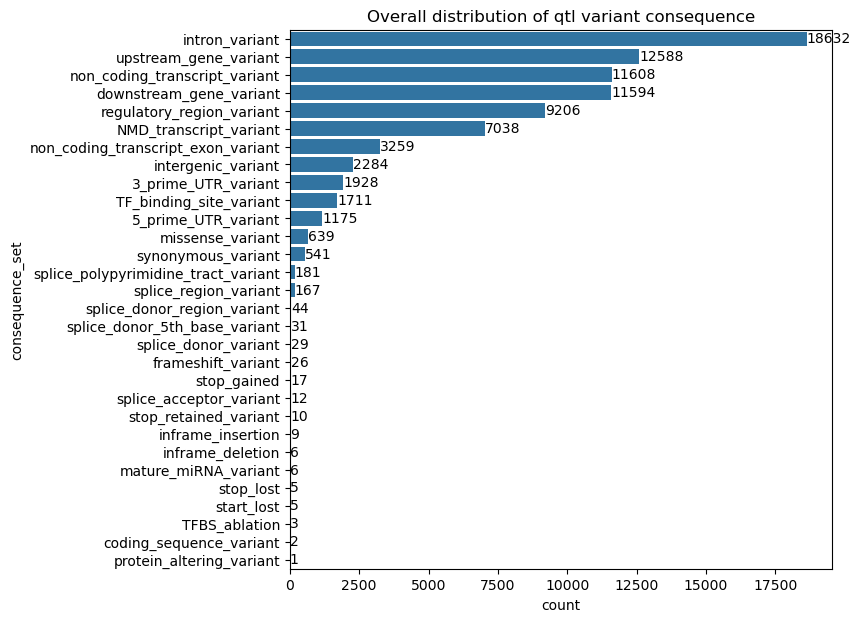

In [124]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_c_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
y = sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_c_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

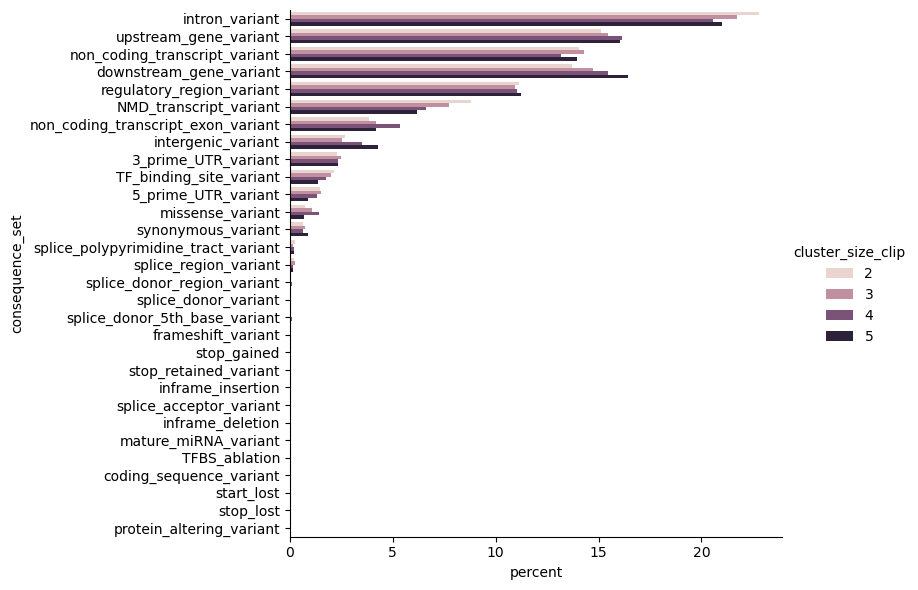

In [125]:
vep_df['cluster_size_clip'] = vep_df['cluster_size'].clip(0,5)
data_to_plot = vep_df.explode('consequence_set').groupby('cluster_size_clip')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='cluster_size_clip',kind='bar',height=6, aspect=1.4)


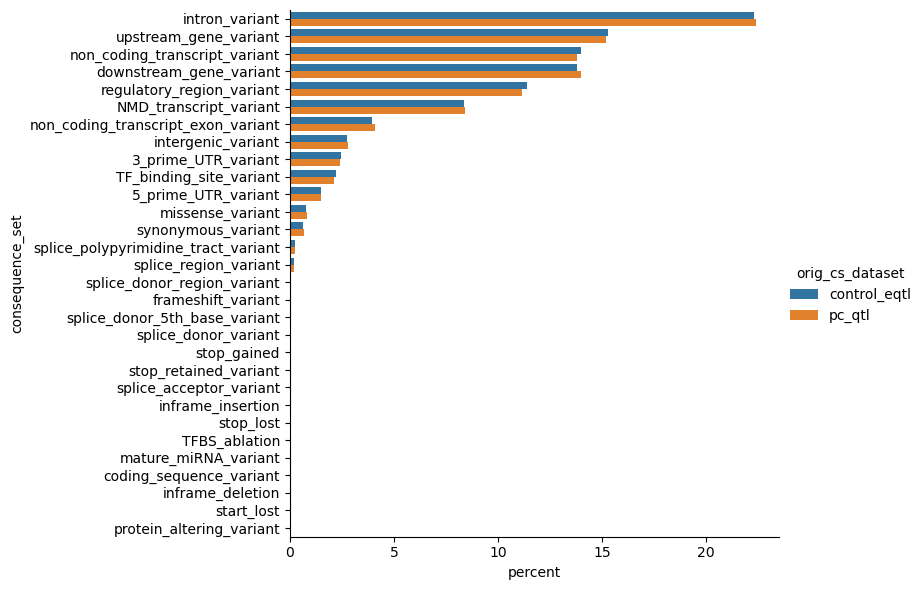

In [136]:
data_to_plot = vep_df.explode('orig_cs_dataset').explode('consequence_set').groupby('orig_cs_dataset')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='orig_cs_dataset',kind='bar', height=6, aspect=1.4)

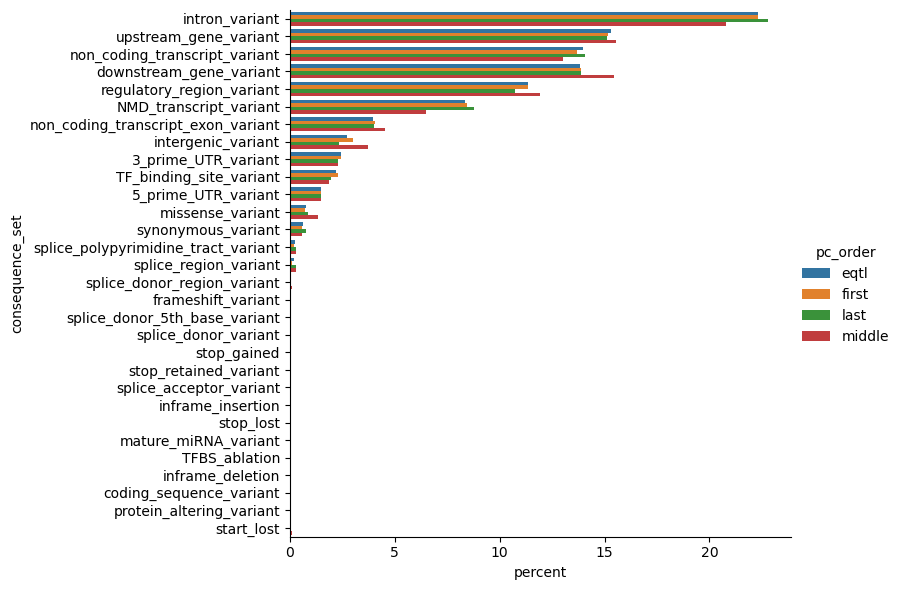

In [137]:
data_to_plot = vep_df.explode('pc_order').explode('consequence_set').groupby('pc_order')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


##### log odds

In [138]:
# error bars on log odds come from error propegation for counts
def calculate_log_odds_error(counts1_positive, counts1_total, counts2_positive, counts2_total):
    counts1_negative = counts1_total-counts1_positive
    counts2_negative = counts2_total-counts2_positive

    # calculate the odds ratio
    or_ratio = (counts1_positive / counts1_negative) / (counts2_positive / counts2_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/counts1_positive - 1/counts1_negative + 1/counts2_positive - 1/counts2_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return np.log2(or_ratio), np.log2(lower_bound), np.log2(upper_bound)


def get_or_counts(vep_df, key_col='consequence_set'):
    return vep_df.explode(key_col).value_counts(key_col)

def get_odds_df(counts1, name1, counts2, name2, ordered_categories):
    or_df = pd.DataFrame({name1: counts1, name2: counts2})

    # add the odds ratios and 95% cis
    for idx in or_df.index:
        or_ratio, lower_bound, upper_bound = calculate_log_odds_error(or_df.loc[idx][name1], or_df[name1].sum(), or_df.loc[idx][name2], or_df[name2].sum())
        or_df.loc[idx, 'or_ratio'] = or_ratio
        or_df.loc[idx, 'lower_bound'] = lower_bound
        or_df.loc[idx, 'upper_bound'] = upper_bound

    or_df['upper_err_abs'] = or_df['upper_bound'] - or_df['or_ratio']
    or_df['lower_err_abs'] = or_df['or_ratio'] - or_df['lower_bound']
    return or_df.loc[ordered_categories[ordered_categories.isin(or_df.index)]].reset_index()

def plot_log_odds(or_df, title, key_col='consequence_set', ax=None, offset=-.2):
    if ax==None:
        fig, ax = plt.subplots(figsize=(7,7))
    # reset index to get consequence_set as a column

    ax.errorbar(y=or_df[key_col], x=or_df['or_ratio'], xerr=np.clip(or_df[['lower_err_abs', 'upper_err_abs']].values.transpose(), -3, 3), fmt="o")

    ax.invert_yaxis()
    plt.axvline(0, color='k')
    plt.text(.1, len(or_df)+offset, f'-> {or_df.columns[1]}')
    plt.text(-.1, len(or_df)+offset, f'{or_df.columns[2]} <-', horizontalalignment='right')
    plt.title(title)
    return ax

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant consequences'}>

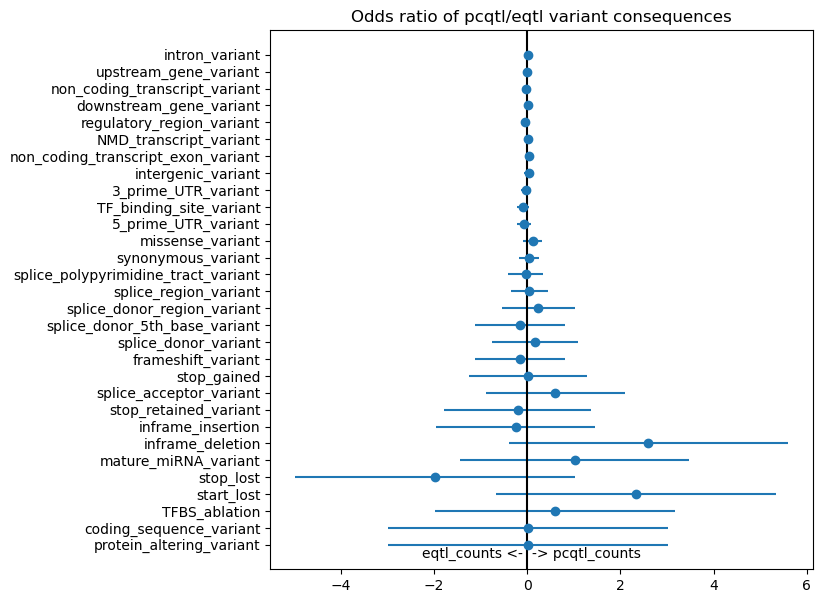

In [139]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of exclusive eqtl/all eqtl variant consequences'}>

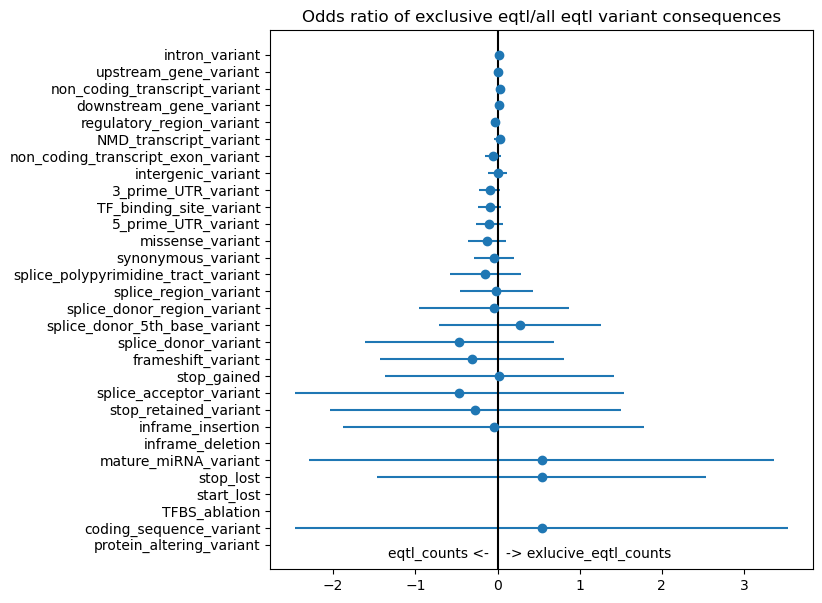

In [140]:
exclusive_eqtl_counts = get_or_counts(vep_df[(vep_df['exclusive_label']=='eqtl_only')])
eqtl_counts = get_or_counts(vep_df[(vep_df['orig_cs_dataset'].astype(str).str.contains('control_eqtl'))])

# format into a df and get the error bars
or_df = get_odds_df(exclusive_eqtl_counts, 'exlucive_eqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of exclusive eqtl/all eqtl variant consequences')

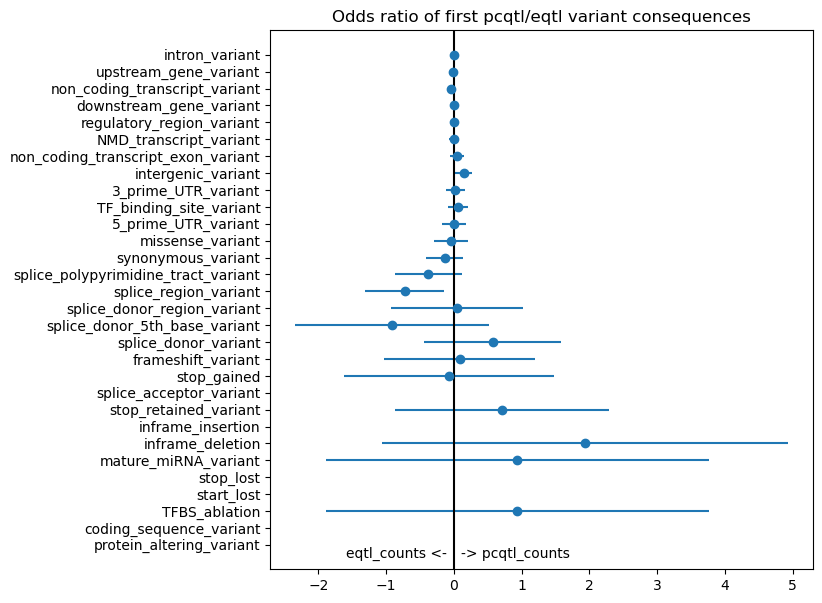

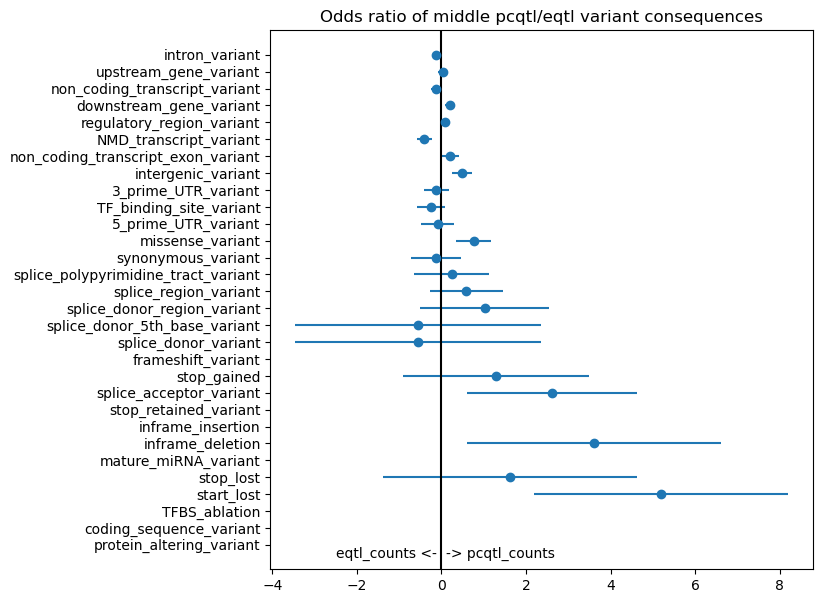

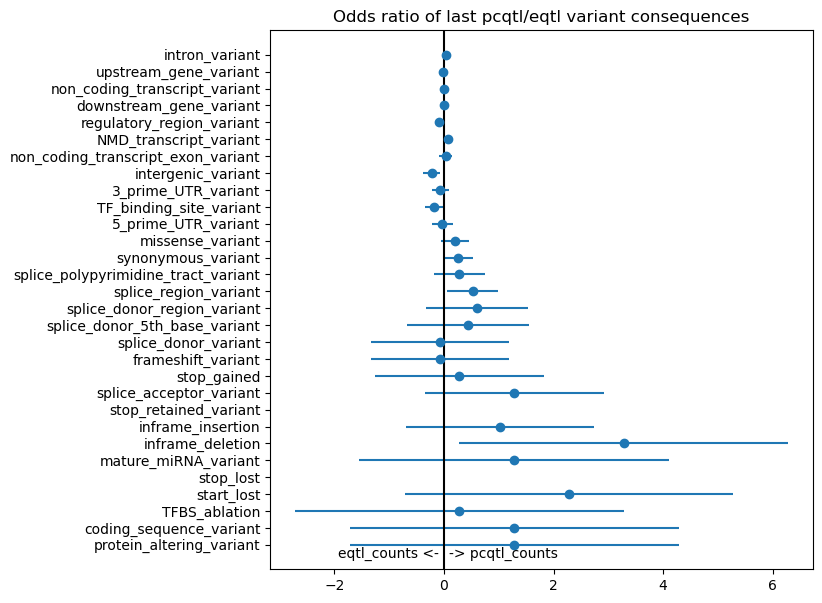

In [141]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order'].astype(str).str.contains(order))])
    eqtl_counts = get_or_counts(vep_df[(vep_df['orig_cs_dataset'].astype(str).str.contains('control_eqtl'))])

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_c_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant consequences'}>

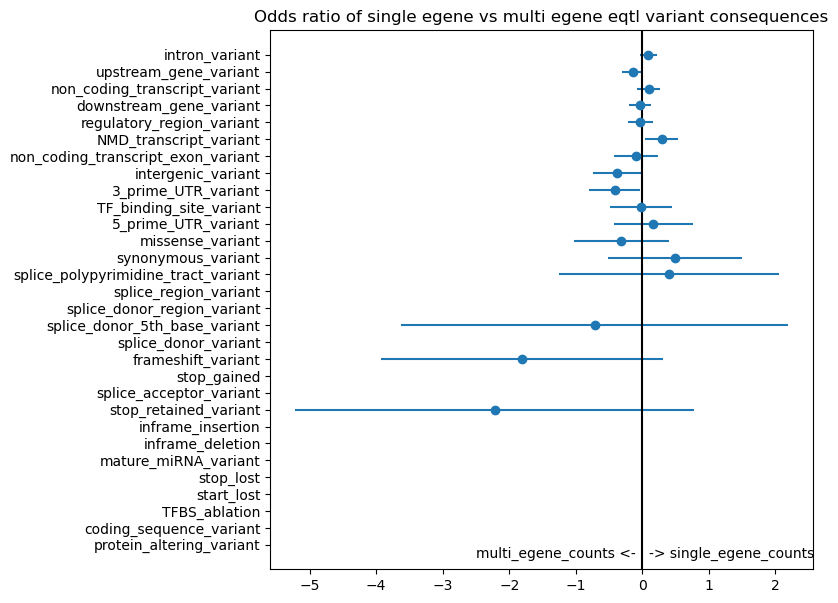

In [149]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']==1)])
multi_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>1)])

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant consequences')

### Biotype

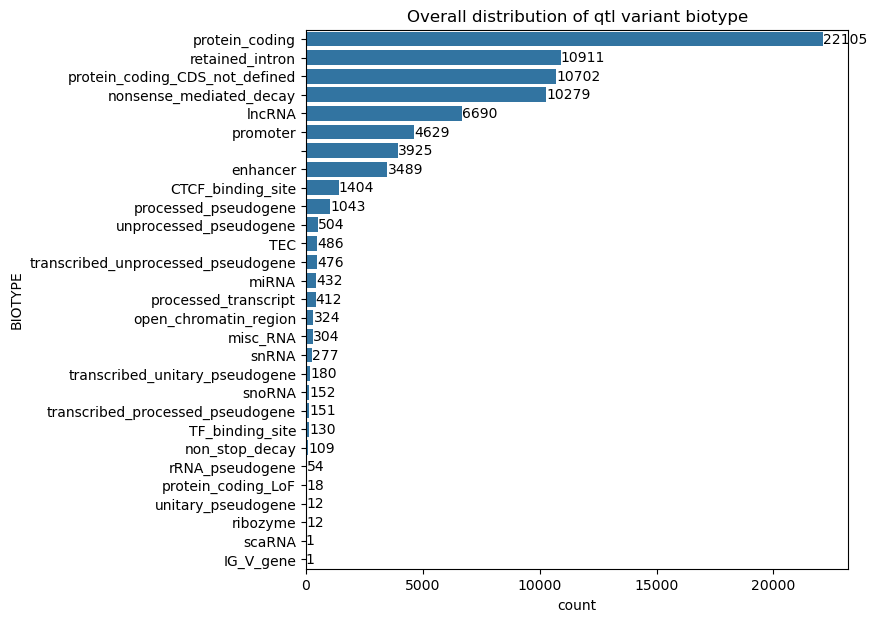

In [150]:
# overall distribution of biotype
fig, ax = plt.subplots(figsize=(7,7))
ordered_b_categories = vep_df.explode('BIOTYPE')['BIOTYPE'].value_counts().index
y = sns.countplot(vep_df.explode('BIOTYPE'), y='BIOTYPE', ax=ax, order=ordered_b_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant biotype')
plt.show()

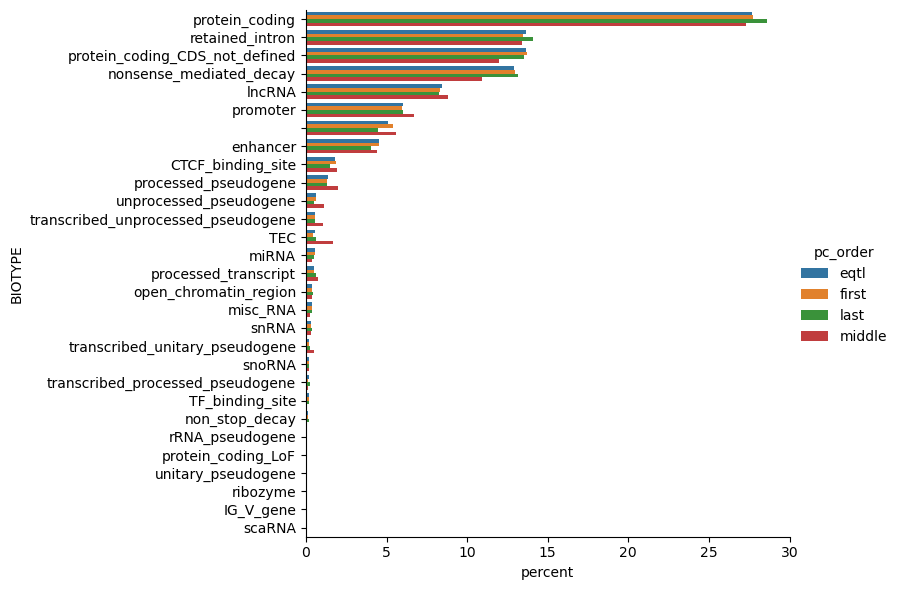

In [152]:
data_to_plot = vep_df.explode('pc_order').explode('BIOTYPE').groupby('pc_order')['BIOTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='BIOTYPE',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant biotype'}>

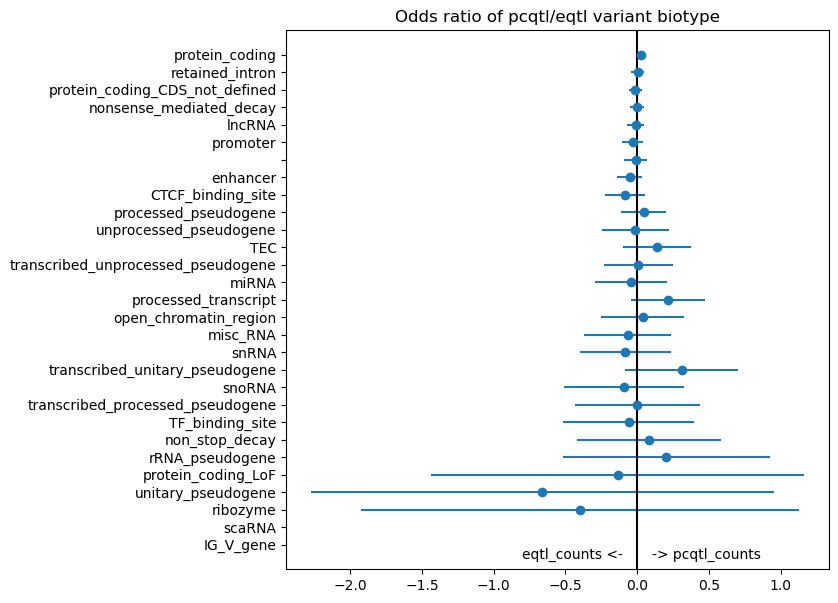

In [153]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)], key_col='BIOTYPE')
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant biotype', key_col='BIOTYPE')

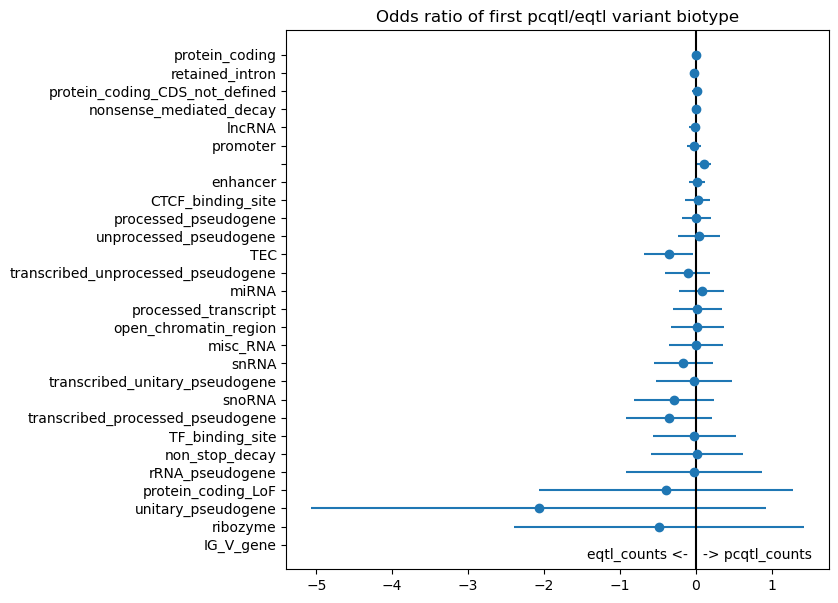

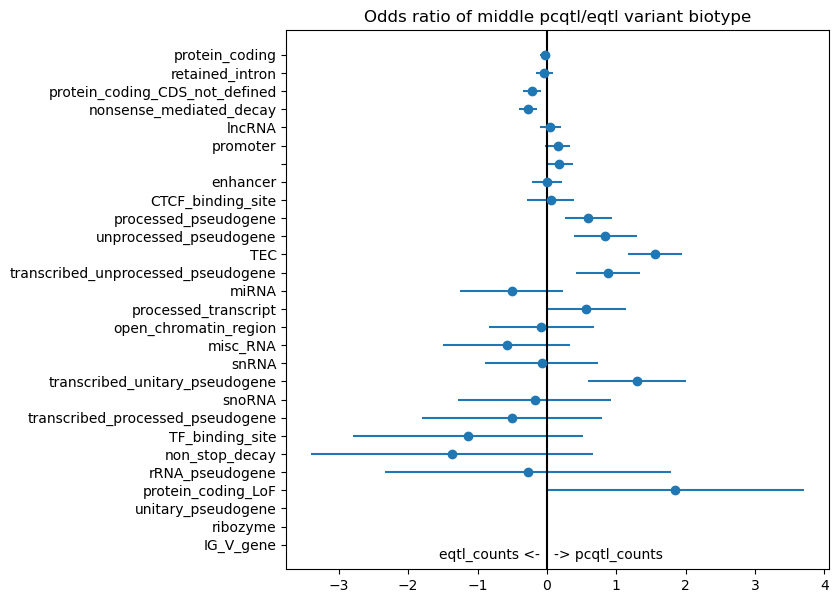

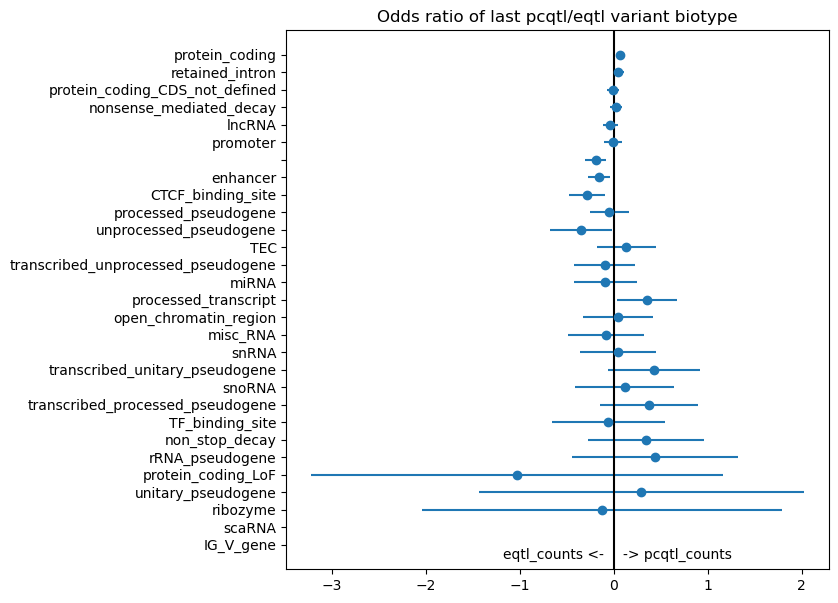

In [155]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order'].astype(str).str.contains(order))],  key_col='BIOTYPE')
    eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)],  key_col='BIOTYPE')

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant biotype',  key_col='BIOTYPE')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant biotype'}>

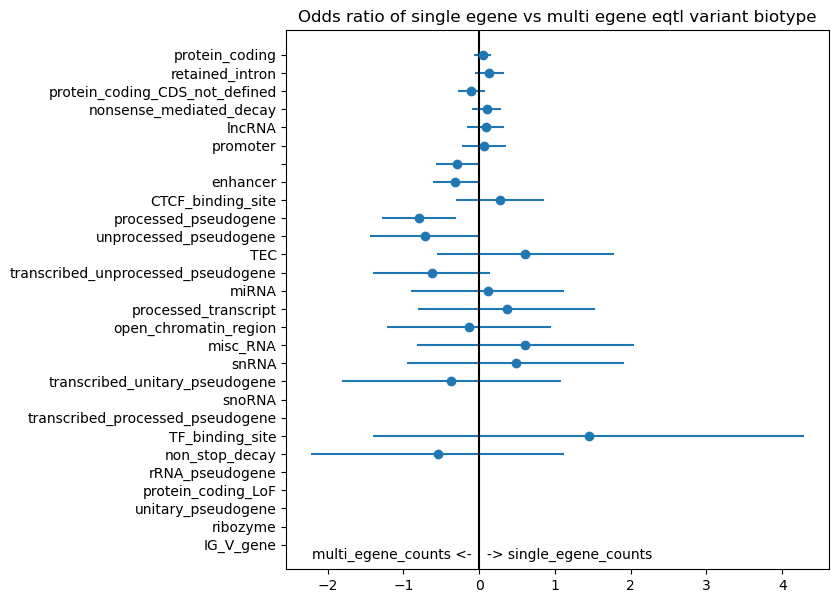

In [156]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']==1)], key_col='BIOTYPE')
multi_egene_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>1)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant biotype', key_col='BIOTYPE')

### Transcription factors

In [157]:
# TFs are split with :: and &
def split_tfs(row):
    split_tfs = [indv_tf for tf in row['TRANSCRIPTION_FACTORS'] for indv_tf in tf.split('&')]
    split_tfs = [indv_tf for tf in split_tfs for indv_tf in tf.split('::')]
    return list(set(split_tfs))

vep_df['tf_set'] = vep_df.apply(split_tfs, axis=1)

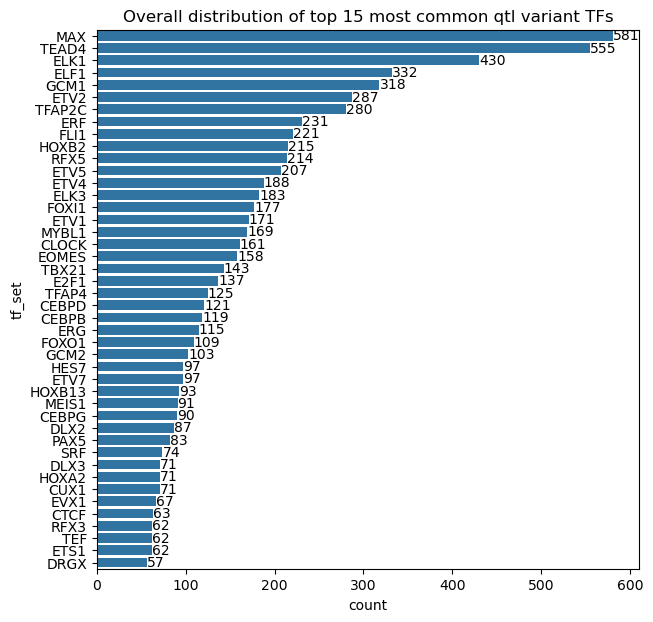

In [158]:
# overall distribution of transcription factors
fig, ax = plt.subplots(figsize=(7,7))
ordered_t_categories = vep_df.explode('tf_set')['tf_set'].value_counts().index
subsample_df = vep_df.explode('tf_set')
subsample_df = subsample_df[subsample_df['tf_set'].isin(ordered_t_categories[1:45])]
y = sns.countplot(subsample_df, y='tf_set', ax=ax, order=ordered_t_categories[1:45])
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of top 15 most common qtl variant TFs')
plt.show()

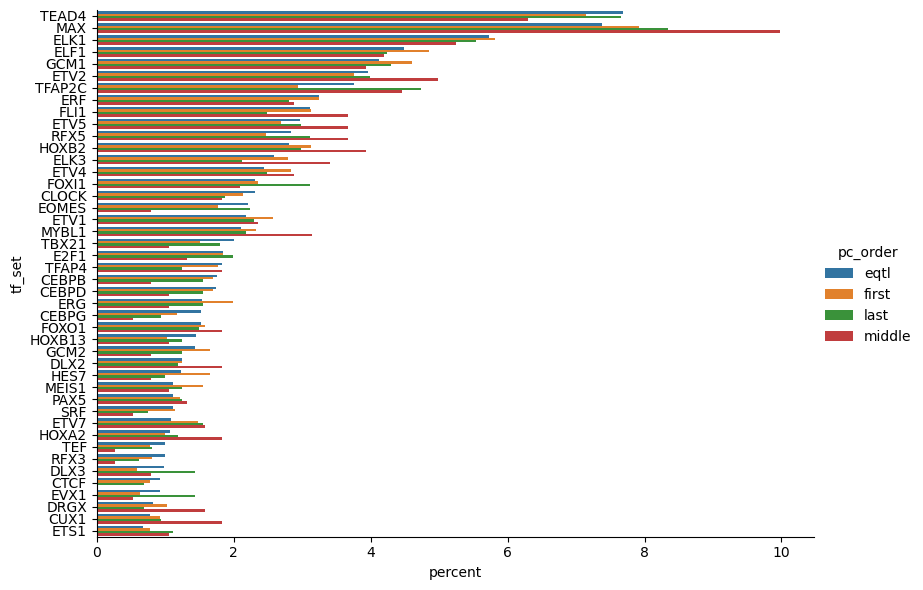

In [160]:
data_to_plot = subsample_df.explode('pc_order').explode('tf_set').groupby('pc_order')['tf_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='tf_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant tf'}>

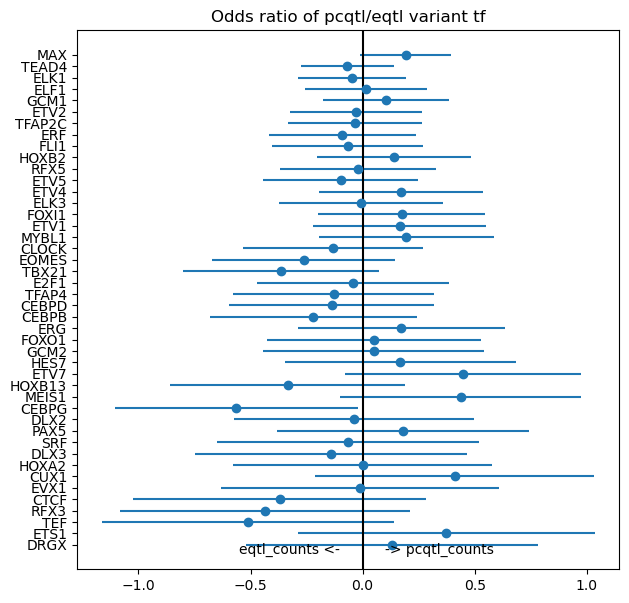

In [161]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(subsample_df[(subsample_df['num_pc_samelead']>0)], key_col='tf_set')
eqtl_counts = get_or_counts(subsample_df[(subsample_df['num_e_samelead']>0)], key_col='tf_set')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_t_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant tf', key_col='tf_set')

## for presnetaitons

highlight a few interesting columns


**consequence**

NMD 

regulatory

TF binding

**biotype**

CTCF

enhancer

promotor

In [162]:
def selected_feature_or_df(df1, name1, df2, name2, features):
    # get biotype df
    df1_counts = get_or_counts(df1, key_col='BIOTYPE')
    df2_counts = get_or_counts(df2, key_col='BIOTYPE')

    # format into a df and get the error bars
    bio_or_df = get_odds_df(df1_counts, name1, df2_counts, name2 , ordered_categories=ordered_b_categories)

    # gert conseqeucne df
    df1_counts = get_or_counts(df1)
    df2_counts = get_or_counts(df2)

    # format into a df and get the error bars
    cons_or_df = get_odds_df(df1_counts, name1, df2_counts, name2, ordered_c_categories)

    # make into one df
    bio_or_df=bio_or_df.rename(columns={'BIOTYPE':'feature'})
    cons_or_df = cons_or_df.rename(columns={'consequence_set':'feature'})

    or_df = pd.concat([bio_or_df, cons_or_df])
    return or_df.set_index('feature').loc[features].reset_index()

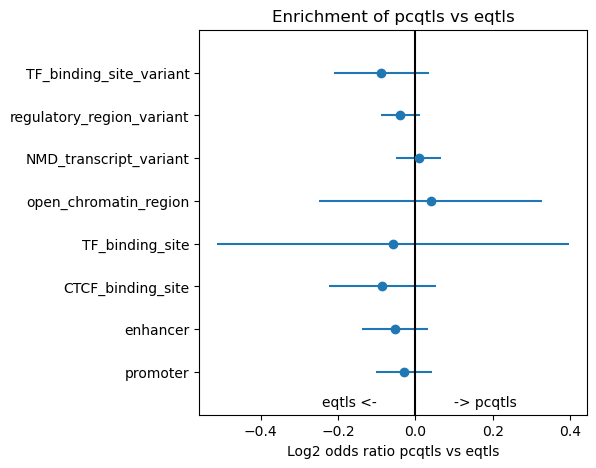

In [169]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['num_pc_samelead']>0], 'pcqtls', vep_df[vep_df['num_e_samelead']>0], 'eqtls', features)



fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio pcqtls vs eqtls')

#ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


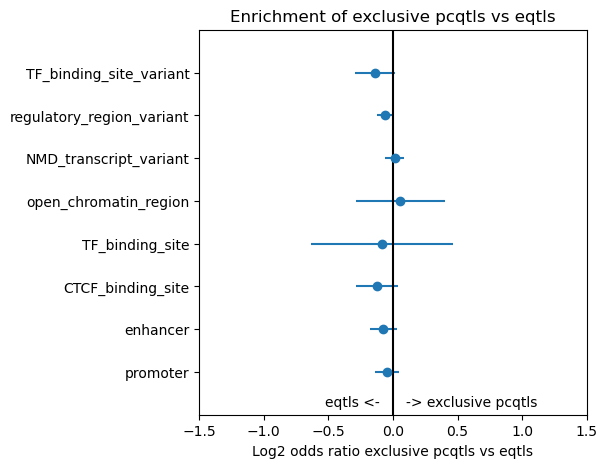

In [172]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['num_e_samelead']==0], 'exclusive pcqtls', vep_df[vep_df['num_pc_samelead']==0], 'eqtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of exclusive pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio exclusive pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


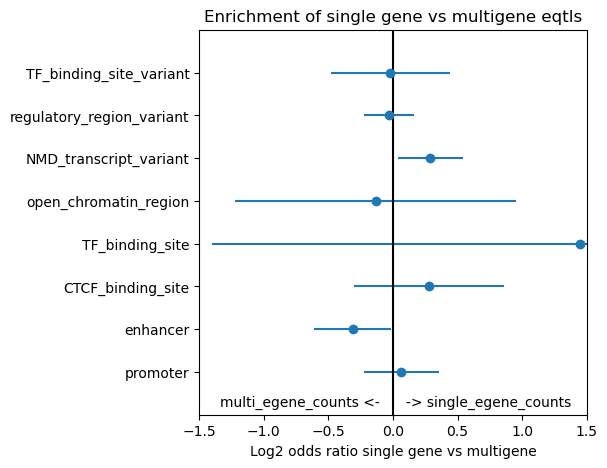

In [167]:

# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']

or_df = selected_feature_or_df(vep_df[(vep_df['num_e_samelead']==1)], 'single_egene_counts', vep_df[(vep_df['num_e_samelead']>1)], 'multi_egene_counts', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of single gene vs multigene eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()

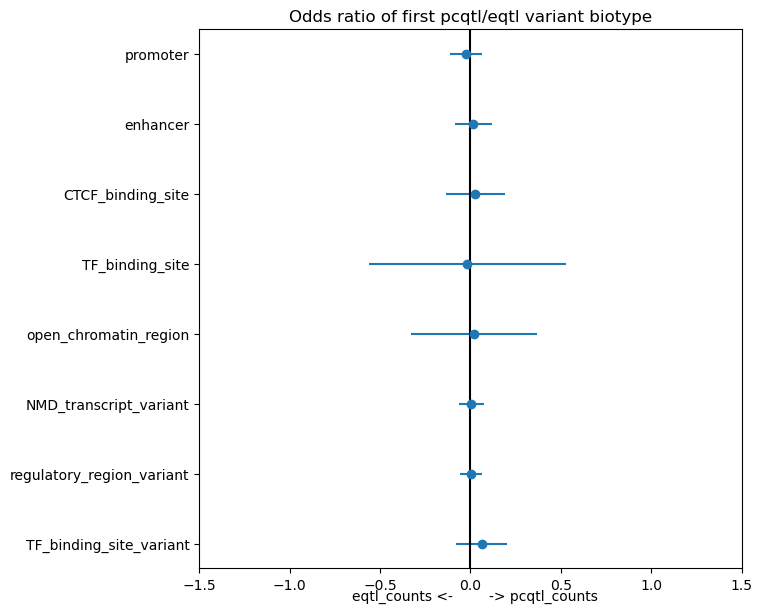

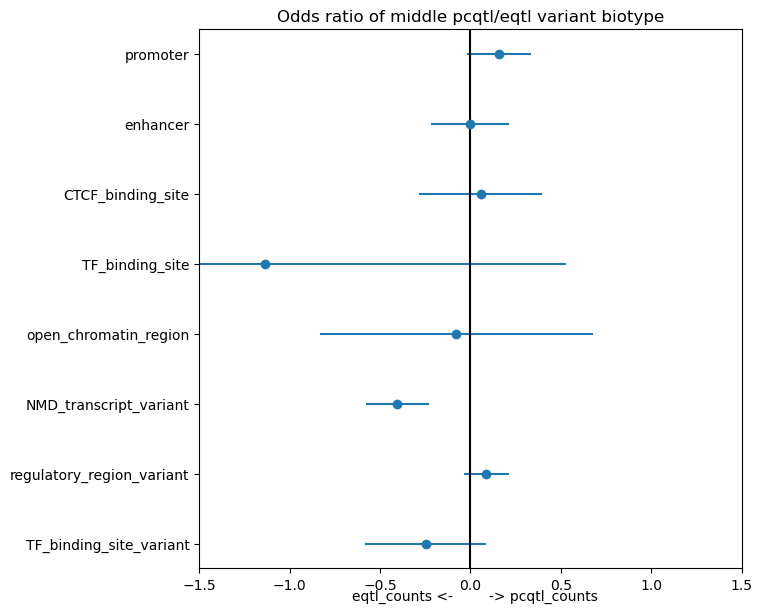

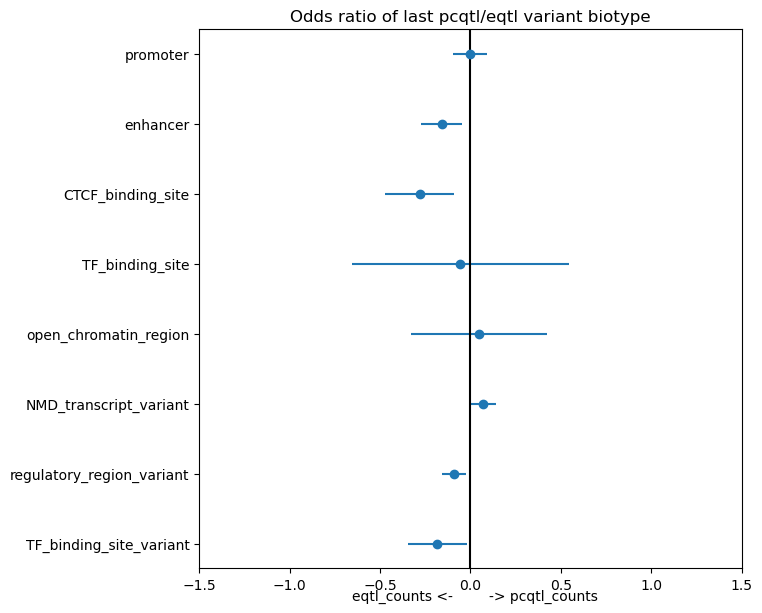

In [168]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    # format into a df and get the error bars
    or_df = selected_feature_or_df(vep_df[(vep_df['pc_order'].astype(str).str.contains(order))], 'pcqtl_counts', vep_df[(vep_df['num_e_samelead']>0)], 'eqtl_counts', features)
    # plot
    ax = plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant biotype',  key_col='feature')
    ax.set_xlim(-1.5, 1.5)
